In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt

from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import decomposition

In [2]:
# Constants
NORMAL = 0
INTERICTAL = 1
ICTAL = 2

In [3]:
# Creating file_list for data
data_path = "C:\\Users\\camer\\Desktop\\Neurovigil\\EEG_Data\\"
folder_names = ['Z_normal', 'O_normal', 'N_interictal', 
                'F_interictal', 'S_ictal']
state_label = [NORMAL]*200 + [INTERICTAL]*200 + [ICTAL]*100
label_list = [data_path + "Z_normal" + "\\*.txt",
             data_path + "O_normal" + "\\*.txt",
             data_path + "N_interictal" + "\\*.txt",
             data_path + "F_interictal" + "\\*.txt",
             data_path + "S_ictal" + "\\*.txt"]
file_list = []
for label in label_list:
    file_list += glob.glob(label)
    
# Pulling data
data = [[]]*500
i = 0
for file in file_list:
    arr = open(file).read()
    data[i] = ([int(x) for x in arr.split()])
    i += 1
data = np.array(data)
data_transpose = np.transpose(data)

In [4]:
# Variable/data organization
normal = data[:200]
y_normal = state_label[:200]
interictal = data[200:400]
y_interictal = state_label[200:400]
ictal = data[400:]
y_ictal = state_label[400:]

data_norm_inter = np.concatenate((normal, interictal), axis=0)
data_norm_ict = np.concatenate((normal, ictal), axis=0)
data_inter_ict = np.concatenate((interictal, ictal), axis=0)
y_norm_inter = label_binarize(np.concatenate((y_normal, y_interictal), axis=0), classes=[0,1])
y_norm_ict = label_binarize(np.concatenate((y_normal, y_ictal), axis=0), classes=[0,2])
y_inter_ict = label_binarize(np.concatenate((y_interictal, y_ictal), axis=0), classes=[1,2])

n_classes = 2

In [5]:
# Using PCA to first decide where %95 of the data is, then fit to that %95
def my_preprocessing(data, display):
    data = preprocessing.scale(data)
    pca1 = decomposition.PCA()
    pca1.fit(data)
    minimum_data = 0
    components = 0
    for i in pca1.explained_variance_ratio_:
        minimum_data += i
        components += 1
        if minimum_data > 0.90:
#            print("minimum_data = " + str(minimum_data) + "\nafter x components:" + str(components))
            break
    pca = decomposition.PCA(n_components = components)
    data = pca.fit_transform(data)
    return data

In [6]:
# Recursively finds channels to prune by brute force
def find_worst_channel(data, y, alpha, best, deleted, removed, num_people):
    channel_dict = dict()
    adjustor = 0
    for i in range(100 - deleted):
        adjustor = 0
        data_minus = np.delete(data, i, axis=0)
        y_minus = np.delete(y, i, axis=0)
        adjustor += 1
        for j in range(num_people - 1):
            j += 1
            remove_line = (j * 100) + i - adjustor
            data_minus = np.delete(data_minus, remove_line, axis=0)
            y_minus = np.delete(y_minus, remove_line, axis=0)
            adjustor += 1
        accuracy = run_decision_tree(data_minus, y_minus, alpha, False)
        if accuracy == 1.0:
            removed[deleted] = i
            return data_minus, y_minus, removed, 1.0
        channel_dict[accuracy] = i
    highest_acc = max(channel_dict.keys())
    worst = channel_dict[highest_acc]
    removed[deleted] = worst
    if highest_acc >= best:
        return find_worst_channel(data_minus, y_minus, alpha, highest_acc, deleted + num_people,
                                  removed, num_people)
    else:
        return data_minus, y_minus, removed, highest_acc

In [7]:
# Create, train, test a Decision Tree Model
def decision_tree_model(x_train, y_train, x_test, y_test, alpha, display):
    decision_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    decision_tree.fit(x_train, y_train)
    score = decision_tree.score(x_test, y_test)
    if display:
        plot_roc_curve(decision_tree, x_test, y_test)
        print(score)
    return score

def run_decision_tree(data, y, alpha, display):
    data = my_preprocessing(data, display)
    x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0)
    accuracy = decision_tree_model(x_train, y_train, x_test, y_test, alpha, display)
    return accuracy

In [8]:
# Finding the best pruning factor for Decision Tree Model
def find_alpha(data, y):
    data = my_preprocessing(data, False)
    x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0)    
    path = DecisionTreeClassifier(random_state=0).cost_complexity_pruning_path(x_train, y_train)
    ccp_alphas = path.ccp_alphas
    ccp_alphas = ccp_alphas[:-1]
    all_dts = []
    for ccp_alpha in ccp_alphas:     
        new_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        new_dt.fit(x_train, y_train)
        all_dts.append(new_dt)
    
    train_scores_dict = dict()
    test_scores_dict = dict()
    train_scores = []
    test_scores = []
    i = 0
    for dt in all_dts:
        train_scores.append(dt.score(x_train, y_train))
        test_scores.append(dt.score(x_test, y_test))
        train_scores_dict[train_scores[i]] = dt.ccp_alpha
        test_scores_dict[test_scores[i]] = dt.ccp_alpha
        i += 1
    
    fig, ax = plt.subplots()
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs alpha for training and testing sets")
    ax.plot(ccp_alphas, train_scores, marker='o', label="train",
            drawstyle="steps-post")
    ax.plot(ccp_alphas, test_scores, marker='o', label="test",
            drawstyle="steps-post")
    ax.legend()
    plt.show()
    
    return test_scores_dict[max(test_scores_dict.keys())]

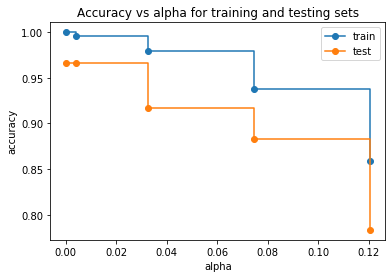

In [9]:
alpha_norm_ict = find_alpha(data_norm_ict, y_norm_ict)

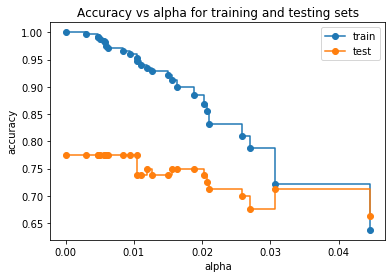

In [10]:
alpha_norm_inter = find_alpha(data_norm_inter, y_norm_inter)

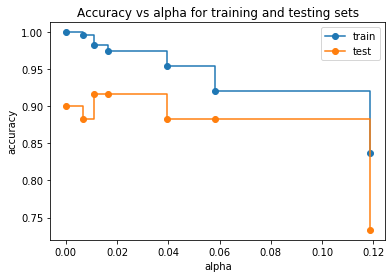

In [11]:
alpha_inter_ict = find_alpha(data_inter_ict, y_inter_ict)

In [12]:
remove = dict()
data_norm_ict, y_norm_ict, removed_norm_ict, best_norm_ict = find_worst_channel(data_norm_ict, y_norm_ict,
                                                                 alpha_norm_ict, 0, 0, remove, 3)
remove.clear()

In [13]:
data_inter_ict, y_inter_ict, removed_inter_ict, best_inter_ict = find_worst_channel(data_inter_ict, y_inter_ict,
                                                                      alpha_inter_ict, 0, 0, remove, 3)

0.9833333333333333


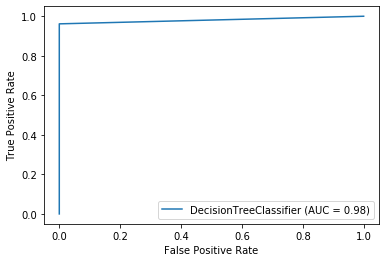

In [14]:
acc_norm_ict = run_decision_tree(data_norm_ict, y_norm_ict, alpha_norm_ict, True)

0.7625


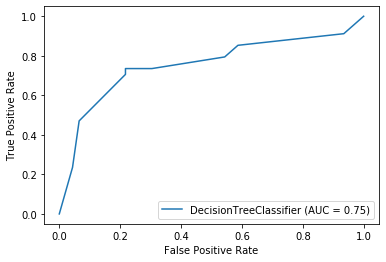

In [15]:
acc_norm_inter = run_decision_tree(data_norm_inter, y_norm_inter, alpha_norm_inter, True)

1.0


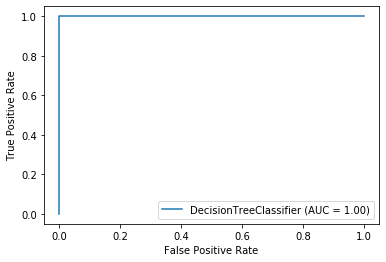

In [16]:
acc_inter_ict = run_decision_tree(data_inter_ict, y_inter_ict, alpha_inter_ict, True)